In [136]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from highlight_text import fig_text, ax_text

df = pd.read_csv('WHR2024.csv')

# rename column
len_to_remove = len('Explained by: ')
for col in df.columns:
    if 'Explained by: ' in col:
        new_name = col[len_to_remove:]
        df[new_name] = df[col]
        df.drop(col, axis=1, inplace=True)

# create part of each explainer
not_explainers = ['Country name', 'Ladder score',
                  'upperwhisker', 'lowerwhisker', 'total']
explainers = ['Dystopia + residual', 'Log GDP per capita', 'Social support',
              'Healthy life expectancy', 'Freedom to make life choices',
              'Generosity', 'Perceptions of corruption']
for explainer in explainers:
    df['share_'+explainer] = df[explainer]/df['Ladder score']*100

# open and merge with geo data
world = gpd.read_file(
    "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
europe = world[world['CONTINENT'] == 'Europe']
data = europe.merge(
    df, how='left',
    left_on='NAME',
    right_on='Country name'
)
europe.columns
data = data[['geometry']+df.columns.to_list()]
data = data[data['Country name'] != 'Russia']
data.dropna(inplace=True)
data.sample(3)

,geometry,Country name,Ladder score,upperwhisker,lowerwhisker,Dystopia + residual,Log GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,share_Dystopia + residual,share_Log GDP per capita,share_Social support,share_Healthy life expectancy,share_Freedom to make life choices,share_Generosity,share_Perceptions of corruption
13,"POLYGON ((27.98113 59.47537, 27.98112 59.47537...",Estonia,6.448,6.524,6.371,1.138,1.752,1.527,0.657,0.805,0.166,0.401,17.648883,27.171216,23.681762,10.189206,12.484491,2.574442,6.218983
23,"POLYGON ((-9.03482 41.88057, -8.67195 42.13469...",Portugal,6.030,6.134,5.925,1.397,1.728,1.368,0.699,0.757,0.047,0.035,23.167496,28.656716,22.686567,11.592040,12.553897,0.779436,0.580431
25,"POLYGON ((-6.19788 53.86757, -6.03299 53.15316...",Ireland,6.838,6.927,6.749,1.239,2.129,1.390,0.700,0.758,0.205,0.418,18.119333,31.134835,20.327581,10.236911,11.085113,2.997953,6.112899


In [153]:
from matplotlib.colors import LinearSegmentedColormap

def create_gradient_colormap(color1, color2):
    colors = [color1, color2]
    cmap = LinearSegmentedColormap.from_list("custom_gradient", colors, N=256)
    return cmap

colors = {
    'share_Generosity': ['#c9ada7', '#4a4e69'],
    'share_Perceptions of corruption': ['#fcbf49', '#d62828'],
    'share_Freedom to make life choices': ['#f896d8', '#724cf9'],
    'share_Social support': ['#80ed99', '#38a3a5'],
}


def plot_map_on_ax(column, ax, cmap):
    data.plot(
        column=column,
        cmap=cmap,
        edgecolor='black', linewidth=0.2,
        ax=ax
    )
    ax.set_xlim(-13.8, 40)
    ax.set_ylim(32, 72)
    ax.axis('off')

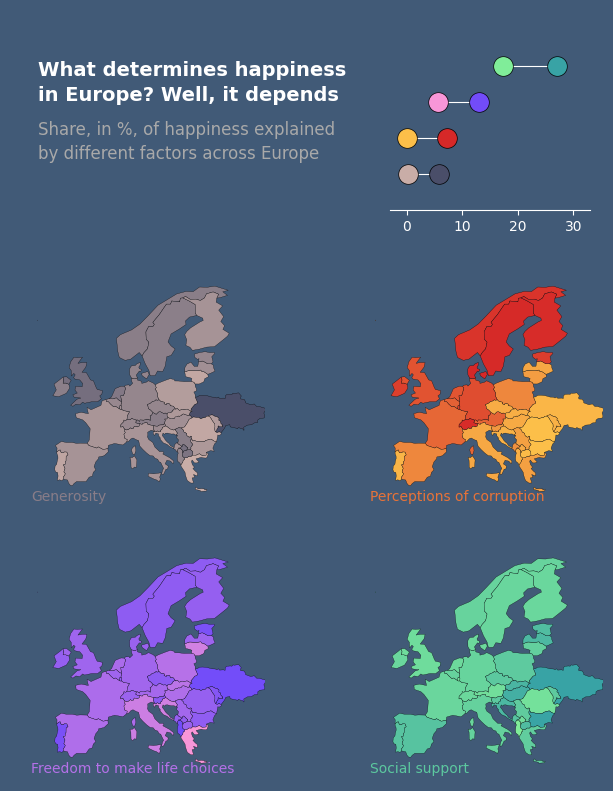

In [154]:
# initialize the figure
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))
axs = axs.flatten()

# set background color
background_col = '#415a77'
fig.set_facecolor(background_col)
axs[1].set_facecolor(background_col)

columns = [
    '','',
    'share_Generosity',
    'share_Perceptions of corruption',
    'share_Freedom to make life choices',
    'share_Social support'
]
for i, (ax, column) in enumerate(zip(axs, columns)):

    # skip first two axes (on top of the maps)
    if i in [0,1]:
        continue

    cmap = create_gradient_colormap(colors[column][0], colors[column][1])
    plot_map_on_ax(column=column, ax=ax, cmap=cmap)

    ax_text(
        -15, 34,
        column[6:], # remove the 'share_' in col name
        ha='left', va='center',
        fontsize=10,
        color=cmap(0.5),
        ax=ax
    )

# Lollipop plot
min_max_df = data[columns[2:]].agg(['min', 'max']).T
for i, col in enumerate(columns[2:]):

    # colors
    min_color = colors[col][0]
    max_color = colors[col][1]

    subset = min_max_df.iloc[i].T
    axs[1].scatter(subset['min'], i, zorder=2,
                   s=200, edgecolor='black', linewidth=0.5, color=min_color)
    axs[1].scatter(subset['max'], i, zorder=2,
                   s=200, edgecolor='black', linewidth=0.5, color=max_color)
axs[1].hlines(
    y=range(4),
    xmin=min_max_df['min'],
    xmax=min_max_df['max'],
    color='white',
    linewidth=0.8,
    zorder=1
)
axs[1].spines[['right', 'top', 'left']].set_visible(False)
axs[1].set_xticks([0, 10, 20, 30, 40])
axs[1].spines['bottom'].set_color('white')
axs[1].tick_params(axis='x', colors='white')
axs[1].set_yticks([])
axs[1].set_ylim(-1, 4)
axs[1].set_xlim(-3, 33)

# remove top left axis
axs[0].set_axis_off()

# title
text = """
<What determines happiness>
<in Europe? Well, it depends>


<Share, in %, of happiness explained>
<by different factors across Europe>
"""
ax_text(
    0.1, 0.55,
    text,
    ha='left', va='center',
    fontsize=14,
    color='black',
    highlight_textprops=[
        {'fontweight': 'bold',
         'color': 'white'},
        {'fontweight': 'bold',
         'color': 'white'},

        {'color': 'darkgrey',
         'fontsize': 12},
        {'color': 'darkgrey',
         'fontsize': 12}
    ],
    ax=axs[0]
)

axs[1].set_position([0.6, 0.68, 0.25, 0.18])

# display the plot
#fig.tight_layout()
fig.savefig('mutliple_maps.png', dpi=300, bbox_inches='tight')
plt.show()

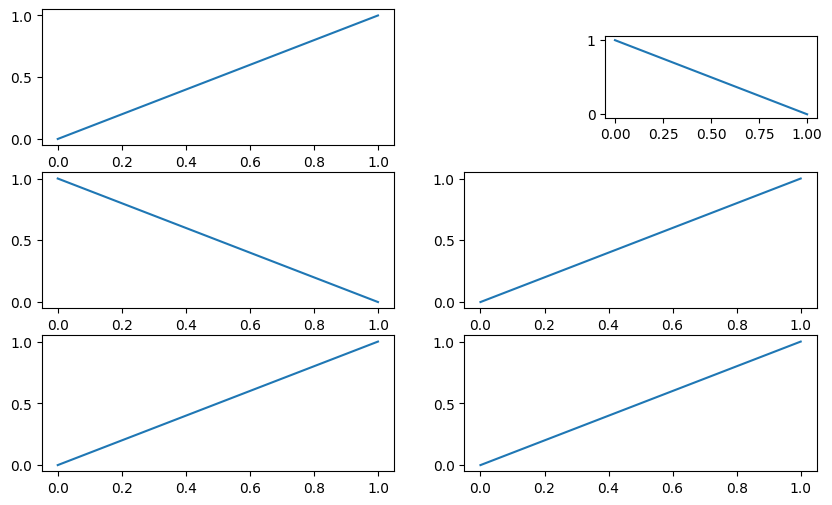

In [68]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a figure
fig = plt.figure(figsize=(10, 6))

# Create a gridspec to manage the layout
gs = gridspec.GridSpec(3, 2, figure=fig)

# Add subplots in their normal positions
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])

# Now, adjust the top right subplot
# Make it smaller and shift it higher
# Parameters are: [left, bottom, width, height] in the figure coordinate system
gs.update()  # Update the grid configuration if necessary
top_right_position = gs[0, 1].get_position(fig)
smaller_width = top_right_position.width * 0.6
smaller_height = top_right_position.height * 0.6
new_left = top_right_position.x0 + (top_right_position.width - smaller_width)
new_bottom = top_right_position.y0 + \
    (top_right_position.height - smaller_height) / 2

# Re-define the top right subplot with new dimensions
ax2.set_position([new_left, new_bottom, smaller_width, smaller_height])

# Plot something in each subplot
ax1.plot([0, 1], [0, 1])
ax2.plot([0, 1], [1, 0])  # Top right plot
ax3.plot([1, 0], [0, 1])
ax4.plot([1, 0], [1, 0])
ax5.plot([0, 1], [0, 1])
ax6.plot([1, 0], [1, 0])

# Show the figure
plt.show()

## to change

- add labels of metrics on lollipop
- change colormap so that start and end colors are not white and black
- add annotations